In [1]:
import mitsuba as mi
import drjit as dr 
import matplotlib.pyplot as plt
mi.set_variant("cuda_ad_rgb")

In [2]:
target = dr.arange(mi.Float,6)
value = dr.arange(mi.Float,6)
index = dr.arange(mi.UInt,6)
dr.scatter_reduce(dr.ReduceOp.Add, target, value=value, index=index)

print(target)

[0.0, 2.0, 4.0, 6.0, 8.0, 10.0]


# Photometric Stereo

input:
- image $I\in\mathbb{R}^{256\times256\times3}$
- Light Source Information
    - LEDs position $P\in\mathbb{R}^{24\times3}$
    - LEDs intensity $S\in\mathbb{R}^{24\times3}$
- Initial Estimation of Surface $Z_0\in\mathbb{R}^{256\times256}$

output:
- Estimation of Surface $Z\in\mathbb{R}^{256\times256}$

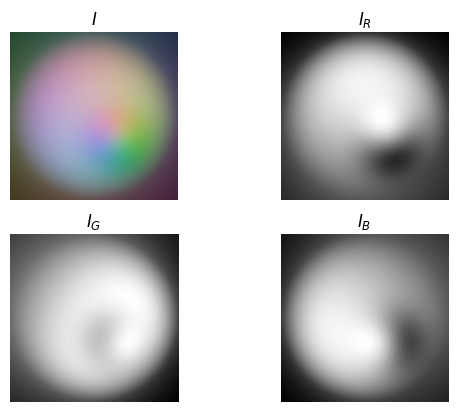

In [3]:
## get image I ##
bmp = mi.Bitmap('../scenes/img/normal-10-10.png')

I_t = mi.TensorXf(bmp)/256

I_R = I_t[:,:,0]
I_G = I_t[:,:,1]
I_B = I_t[:,:,2]

f, ax = plt.subplots(2,2)
ax[0,0].imshow(I_t); ax[0,0].axis('off');ax[0,0].set_title("$I$")
ax[0,1].imshow(I_R,cmap='gray');ax[0,1].axis('off');ax[0,1].set_title("$I_R$");
ax[1,0].imshow(I_G,cmap='gray');ax[1,0].axis('off');ax[1,0].set_title("$I_G$");
ax[1,1].imshow(I_B,cmap='gray');ax[1,1].axis('off');ax[1,1].set_title("$I_B$");

In [4]:
## get LED position P_LED and Direction D_LED ##
N_LED = 24
LED0_pos = mi.Point3f(-34.41,0,-12.5)
angle = 2*dr.pi/N_LED*dr.arange(mi.Float,N_LED)
Q = dr.rotate(mi.Quaternion4f,mi.Vector3f(0, 0, 1),angle)
P_LED = dr.quat_to_matrix(Q, 3)@LED0_pos

D_LED = -P_LED
D_LED.z = 0
D_LED = dr.normalize(D_LED)

In [5]:
## get LED intensity ##
A = 0.4
B = 0.5

i_list = dr.arange(mi.Float,N_LED)

S = mi.TensorXf(0,[1,N_LED,1,3])

S[:,:,:,0] = A*dr.sin(2*dr.pi/N_LED*i_list)+B
S[:,:,:,1] = A*dr.sin(2*dr.pi/N_LED*(i_list-N_LED/3))+B
S[:,:,:,2] = A*dr.sin(2*dr.pi/N_LED*(i_list+N_LED/3))+B

In [6]:
## Initial Estimation of Surface Z0 ##
M = 128
N = 128

Z0 = mi.TensorXf(0,[M,N])

from utils.meshbuilder import grid_mesh_build
mesh = grid_mesh_build([-36,-36],[36,36],[M,N],Z0.array)

scene = mi.load_dict({
    "type": "scene",
    "facedisk": mesh,
})



# Step 1: Get estimation position of each pixel

In [7]:
### Image pixel resolution ###
image_res = (256, 256)
### camera origin          ###
cam_origin = mi.Point3f(0,0,-50)
### camera fov in mm       ###
cam_fov = (70,70)

import utils.camera 
cam = utils.camera.Camera(cam_origin, image_res,cam_fov)

### compute the surface interactions ###
si = cam.shot(scene)

# Step 2: Get incident direction/intensity for each LED 

In [8]:
# compute incident direction D_incident
P_LED_t = mi.TensorXf(dr.ravel(P_LED),shape=[1,N_LED,3])
N_Pixel = image_res[0]*image_res[1]
P_Pixel_t = mi.TensorXf(dr.ravel(si.p),shape=[N_Pixel,1,3])
norm_Pixel = dr.select(si.is_valid(),si.n,0)
norm_Pixel_t = mi.TensorXf(dr.ravel(norm_Pixel),shape=[N_Pixel,1,3])
D_incident = P_Pixel_t - P_LED_t
D_incident_n = mi.TensorXf(dr.block_sum(dr.sqr(D_incident.array),3),shape=[N_Pixel,N_LED,1])
D_incident = D_incident/dr.sqrt(D_incident_n)

# compute angle between incident and LED normal
D_LED_t = mi.TensorXf(dr.ravel(D_LED),shape=[1,N_LED,3])
cosine2 = D_incident*D_LED_t
cosine2 = mi.TensorXf(dr.block_sum(cosine2.array,3),shape=[N_Pixel,N_LED,1,1])
# compute light max intensity  at the angle of the LED
I_LED = dr.select(cosine2>0,cosine2,0)

### Exclude rays that are blocked by surface ###
ray_test_o = P_Pixel_t - mi.TensorXf(0,shape=[1,N_LED,3])
ray_test_o[:,:,2] = ray_test_o[:,:,2].array-10*dr.epsilon(mi.Float)
id_test = dr.arange(mi.UInt,N_Pixel*N_LED)
ray_test_o = dr.gather(mi.Point3f, ray_test_o.array, id_test)
ray_test_d = dr.gather(mi.Vector3f, -D_incident.array, id_test)
ray_test =  mi.Ray3f(o=ray_test_o,d=ray_test_d)
ray_test_result = scene.ray_test(ray_test)
I_LED = dr.select(mi.TensorXb(~ray_test_result,[N_Pixel,N_LED,1,1]),I_LED,0)


# compute intensity of incident with each color
I_inc = I_LED*S

# Step 2: Calculate Matrix R and surface normal            ##

In [9]:
# compute matrix R for each pixel
R0 = mi.TensorXf(D_incident.array,[N_Pixel,N_LED,3,1])*I_inc
k_r,k_g,k_b = 0.2,0.2,0.2
K = [k_r,k_g,k_b]
for i in range(3):
    R0[:,:,:,i] = R0[:,:,:,i].array*K[i]

R_float = dr.zeros(mi.Float,N_Pixel*3*3)
R_index1 = dr.arange(mi.UInt,N_Pixel*3)
R_index2 = dr.arange(mi.UInt,N_Pixel)

a,b,c,d = dr.meshgrid(
    dr.arange(mi.UInt,N_Pixel),
    dr.zeros(mi.UInt,N_LED),
    dr.arange(mi.UInt,3),
    dr.arange(mi.UInt,3),
    indexing='ij' 
)
dr.scatter_reduce(dr.ReduceOp.Add, R_float, value=R0.array, index=a*3*3+c*3+d)
R_array = dr.gather(mi.Vector3f,R_float,R_index1)
R_matrix = dr.gather(mi.Matrix3f,R_array,R_index2)
R_inverse = dr.inverse_transpose(R_matrix)

# compute the normal of surface
I_arr = dr.gather(mi.Vector3f,I_t.array,dr.arange(mi.UInt,N_Pixel))
I_normal = R_inverse@I_arr

# Step 3: Solve the surface by Fast Poisson Solvers 

In [10]:
# calculate gx and gy

# The tactile image of the reconstruction result

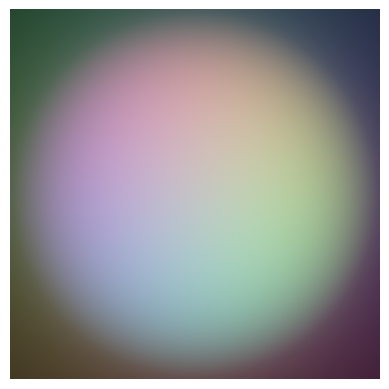

In [11]:
I_compute_arr = dr.transpose(R_matrix)@norm_Pixel
I_compute = mi.TensorXf(dr.ravel(I_compute_arr),(256,256,3))

plt.axis('off')
plt.imshow(I_compute)
plt.show()